## Table of Contents
<ul>
<li><a href="#huge_data_and_how_to_deal_with_it">huge_data_and_how_to_deal_with_it</a></li>
<li><a href="#reduce_memory_function">reduce_memory_function</a></li>
<li><a href="#data_loading">data_loading</a></li> 
<li><a href="#change_movie_id_rows_to_column">change_movie_id_rows_to_column</a></li>
<li><a href="#summary_about_reducing_data_size">summary_about_reducing_data_size</a></li>
<li><a href="#load_movies_data">load_movies_data</a></li>
<li><a href="#cleanning_missing_valuse_with_movies_data">cleanning_missing_valuse_with_movies_data</a></li>
<li><a href="#EDA">EDA</a></li>
<li><a href="#movies_name_with_high_users_rating">movies_name_with_high_users_rating</a></li>
<li><a href="#build_user_profile">build_user_profile</a></li>
<li><a href="#dim_reduction">dim_reduction</a></li>
<li><a href="#user_recommendation_using_KMeans">user_recommendation_using_KMeans</a></li>
<li><a href="#top_10_movies_for_each_cluster">top_10_movies_for_each_cluster</a></li>
<li><a href="#user_recommend_function">user_recommend_function</a></li>
<li><a href="#movie_recommend_function">movie_recommend_function</a></li>
<li><a href="#other_clustring_methods">other_clustring_methods</a></li>

</ul>
                

<a id='huge_data_and_how_to_deal_with_it'></a>
> the problem of huge data , and the ways i used to solve some problems
- becasue we have large dataset i will not use pandas i will use `modin`
- In pandas, you are only able to use one core at a time when you are doing computation of any kind. With Modin, you are able to use all of the CPU cores on your machine. Even in read_csv, we see large gains by efficiently distributing the work across your entire machine.
- secaond thing is that pandas load data with large data type so i should consider reducing the type that will reduce data size
- third thing is to remove usless column this also will help

In [1]:
#import pandas as pd
import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import IncrementalPCA
import warnings
warnings.simplefilter('ignore')

In [ ]:
pip install dask[complete]

In [ ]:
pip install -U modin

In [2]:
import os

os.environ["MODIN_ENGINE"] = "dask"

> data description : 
- The file "training_set.tar" is a tar of a directory containing `17770` files, one
per movie.  
- The first line of each file contains the movie `id` followed by a colon.  Each subsequent line in the file corresponds to a rating from a  customer and its date in the following format:
    - `CustomerID,Rating,Date`
- and there is another file that containes the film title and it's id

> vip : 
- the data is so big so i need to reduce the memory usage , `When you load the dataset into pandas dataframe, the default datatypes assigned to each column are not memory efficient.`
   - note `category` type is better for memory optimization than object type so i will consider that

<a id='reduce_memory_function'></a>

In [27]:
def reduce_mem_usage(df):
    """ 
        iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def import_data(file , names , usecols = [0,1,2] , spe = ' ' , header = False):
    """
    create a dataframe and optimize its memory usage
    file : file of data
    names : names of the columns
    usecols : index of columns that i want to use because somtimes i want to load data without columns
    
    """
    df = pd.read_csv(file, names=names, usecols = usecols)
    df = reduce_mem_usage(df)
    return df

In [30]:
df1 = import_data('./data/combined_data_1.txt' , ['customer_id','rating','rating_date']  )

Memory usage of dataframe is 550.65 MB
Memory usage after optimization is: 203.38 MB
Decreased by 63.1%


In [31]:
df1.head()

,customer_id,rating,rating_date
0,1:,NaN,NaN
1,1488844,3.0,2005-09-06
2,822109,5.0,2005-05-13
3,885013,4.0,2005-10-19
4,30878,4.0,2005-12-26


In [32]:
df1.info()
# we can see that folat was reduce from float64 to float16

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24058263 entries, 0 to 24058262
Data columns (total 3 columns):
 #   Column       Dtype   
---  ------       -----   
 0   customer_id  category
 1   rating       float16 
 2   rating_date  category
dtypes: category(2), float16(1)
memory usage: 203.4 MB


> looking at this data we can see that the first line is has movie id `1:` and then the following row containing `customer id , rating , rating data ` for this movie

> rating date is not useful so let's load the data again without it and see how much memory we reduced

In [33]:
df1 = import_data('./data/combined_data_1.txt' , ['customer_id','rating'] , [0,1])

Memory usage of dataframe is 367.10 MB
Memory usage after optimization is: 157.41 MB
Decreased by 57.1%


> we can see that we reduced that data alot from `505 MB` of the original data to `157 MB` 

<a id='data_loading'></a>
> after knowing the structure of that data i will load all the data now

In [34]:
df = df1.copy()
print('memory of data1')
mem = df.memory_usage().sum() / 1024**2
print(df.shape)
print('Memory usage of all dataframe is {:.2f} MB'.format(mem))
print('========================================================')
for i in range(2,5):
    print(f'memory of data{i}')
    df_ = import_data(f'./data/combined_data_{i}.txt' , ['customer_id','rating'], [0,1])
    print(df_.shape)
    df = df.append(df_)
    mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of all dataframe is {:.2f} MB'.format(mem))
    print('========================================================')

memory of data1
(24058263, 2)
Memory usage of all dataframe is 157.41 MB
memory of data2
Memory usage of dataframe is 411.72 MB
Memory usage after optimization is: 174.17 MB
Decreased by 57.7%
(26982302, 2)
Memory usage of all dataframe is 876.17 MB
memory of data3
Memory usage of dataframe is 344.94 MB
Memory usage after optimization is: 149.13 MB
Decreased by 56.8%
(22605786, 2)
Memory usage of all dataframe is 1264.22 MB
memory of data4
Memory usage of dataframe is 409.73 MB
Memory usage after optimization is: 173.44 MB
Decreased by 57.7%
(26851926, 2)
Memory usage of all dataframe is 1725.17 MB


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100498277 entries, 0 to 26851925
Data columns (total 2 columns):
 #   Column       Dtype  
---  ------       -----  
 0   customer_id  object 
 1   rating       float16
dtypes: float16(1), object(1)
memory usage: 1.7+ GB


> we have customer is as object so let's convert it to int because we will need this for ML model

In [108]:
df['customer_id'] = df['customer_id'].astype(np.int32)

In [36]:
# let's arang the data 
df.index = np.arange(0,len(df))
df.head(10)

,customer_id,rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0
5,823519,3.0
6,893988,3.0
7,124105,4.0
8,1248029,3.0
9,1842128,4.0


> note that we can get the sum of the rows of movie ids 

In [51]:
df['rating'].isnull().sum()

17770

In [64]:
movie_indexes = df.loc[df['rating'].isnull()].index

> what i want to do is to remove `movie id` rows and add column refer to it

In [93]:
df.loc[movie_indexes[0]+1:movie_indexes[0+1]].movie_id.replace(df.loc[movie_indexes[0]+1:movie_indexes[0+1]].movie_id.values , 7 , inplace = True)

<a id='change_movie_id_rows_to_column'></a>

In [ ]:
for i in range(len(movie_indexes)): # 0 to 17769
    values = df[movie_indexes[i]+1:movie_indexes[i+1]]['movie_id'].values
    update_values = df.iloc[movie_indexes[i]][0].replace(':','')
    if (i != len(movie_indexes)-1 ):
        df[movie_indexes[i]+1:movie_indexes[i+1]]['movie_id'].replace(values ,update_values , inplace = True )
    else:
        df[movie_indexes[i]+1:]['movie_id'].replace(values ,update_values , inplace = True )

> now let's remove these rows 

In [98]:
df = df[pd.notnull(df['rating'])]

In [107]:
df.head()

,customer_id,rating,movie_id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1


In [5]:
df['movie_id'] = df['movie_id'].astype(np.int16)
#np.int16 because i want to save memorey and max number for movie ids is 17770 so int16 will be enough
df['rating'] = df['rating'] .astype(np.int8) 

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100480507 entries, 1 to 100498276
Data columns (total 3 columns):
 #   Column       Dtype
---  ------       -----
 0   customer_id  int32
 1   rating       int8 
 2   movie_id     int16
dtypes: int16(1), int32(1), int8(1)
memory usage: 1.4 GB


In [151]:
df.head()

,customer_id,rating,movie_id
1,1488844,3,1
2,822109,5,1
3,885013,4,1
4,30878,4,1
5,823519,3,1


<a id='summary_about_reducing_data_size'></a>
> we can note that after correcting the data types , the size is now 1.4 GB and before it was 1.7 GB
- so the total data before was `2.2` GB now it's `1.4` GB which is much better of course
- so we reduced the memory by correcting the data types , and we overcome the speed problem by using `modin.pandas`

> it took us alot of time to clean the data so far so let's save it so we can load it cleaned the next time or if problem happened with the kernal

In [75]:
if not os.path.isfile('customers_data.csv'):
    df.to_csv('customers_data.csv', index=False)
else :
    df = pd.read_csv('./customers_data.csv')

In [76]:
df['movie_id'] = df['movie_id'].astype(np.int16)
df['customer_id'] = df['customer_id'].astype(np.int32) 
df['rating'] = df['rating'] .astype(np.int8) 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100480507 entries, 0 to 100480506
Data columns (total 3 columns):
 #   Column       Dtype
---  ------       -----
 0   customer_id  int32
 1   rating       int8 
 2   movie_id     int16
dtypes: int16(1), int32(1), int8(1)
memory usage: 670.8 MB


<a id='load_movies_data'></a>

In [71]:
movies = pd.read_csv('./data/movie_titles.csv' , encoding = "ISO-8859-1", names = ['movie_id', 'year', 'title' ] , usecols=[0,1,2])

In [8]:
movies.head(5)

,movie_id,year,title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [9]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   movie_id  17770 non-null  int64  
 1   year      17763 non-null  float64
 2   title     17770 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 416.6+ KB


> some movies like the ones in index `71 , 263 , 5916` have values in cloumns `4,5,6` but these values is not useful so i will only use the first 3 columns
- and note that this `csv file` has no header so if i did not spacifiy the names of the columns it will use the first row as the names of the columns  
- and there will be an encoding error if we removed the encoding parameter but if we search the error they will recommend encode this file using `ISO-8859-1`

<a id='cleanning_missing_valuse_with_movies_data'></a>
> movies cleaing :
- we need to chnage the data types of all the columns there are some missing values so we should fix them

In [10]:
movies.loc[movies['year'].isnull()]

,movie_id,year,title
4387,4388,NaN,Ancient Civilizations: Rome and Pompeii
4793,4794,NaN,Ancient Civilizations: Land of the Pharaohs
7240,7241,NaN,Ancient Civilizations: Athens and Greece
10781,10782,NaN,Roti Kapada Aur Makaan
15917,15918,NaN,Hote Hote Pyaar Ho Gaya
16677,16678,NaN,Jimmy Hollywood
17666,17667,NaN,Eros Dance Dhamaka


> here we have domain knolowage so the easiest and best thing to do is to get these missing years from google  

In [57]:
movies_dict = {'Eros Dance Dhamaka':1999,
               'Jimmy Hollywood':1994,
               'Hote Hote Pyaar Ho Gaya' :1999,
               'Roti Kapada Aur Makaan':1974,
               'Ancient Civilizations: Athens and Greece':1994,
               'Ancient Civilizations: Land of the Pharaohs':1995,
               'Ancient Civilizations: Rome and Pompeii':2014}

In [58]:
for key ,value in  zip(movies_dict.keys() , movies_dict.values()):
    movies.loc[movies['title']== key , 'year'] = value

In [13]:
movies.loc[movies['year'].isnull()]

,movie_id,year,title


In [14]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   movie_id  17770 non-null  int64  
 1   year      17770 non-null  float64
 2   title     17770 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 416.6+ KB


> now let's change data types :

In [15]:
movies['year'].max()

2014.0

In [59]:
movies['movie_id'] = movies['movie_id'].astype(np.int16) 
movies['year'] = movies['year'].astype(np.int16) 

In [17]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  17770 non-null  int16 
 1   year      17770 non-null  int16 
 2   title     17770 non-null  object
dtypes: int16(2), object(1)
memory usage: 208.4+ KB


<a id='EDA'></a>
### EDA:

In [18]:
len(movies['year'].unique())

95

In [19]:
movies['year'].max()-movies['year'].min()

118

In [20]:
movies_year_count = movies['year'].value_counts().sort_values(ascending = False)[0:20]

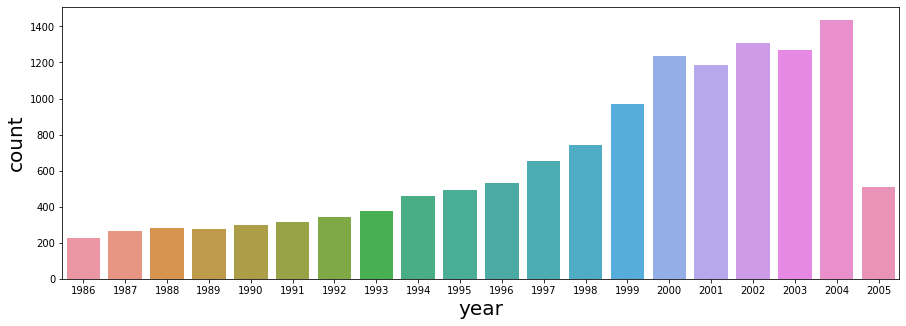

In [21]:
plt.figure(figsize=(15,5))
sns.barplot(movies_year_count.index , movies_year_count.values);
plt.xlabel('year' , size=20)
plt.ylabel('count',size = 20);

In [22]:
rating_count = df['rating'].value_counts()

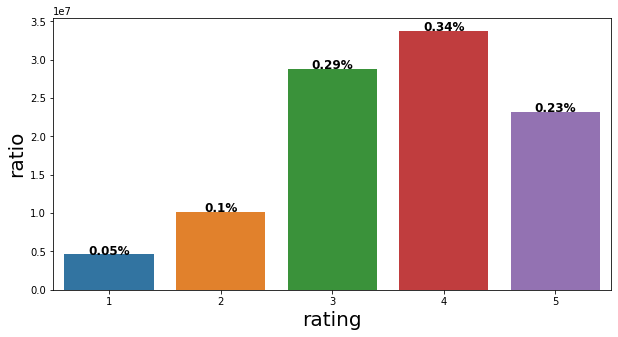

In [23]:
plt.figure(figsize=(10,5))
ax = sns.barplot(rating_count.index , rating_count.values)
for patch in ax.patches:
            loc = patch.get_x()
            width = patch.get_width()
            height = patch.get_height()
            value = round ( (height)/len(df['rating']),2)
            ax.text(loc+width/2, height,  str(value)+'%' , fontsize=12, weight='bold', ha='center')

plt.xlabel('rating' , size=20)
plt.ylabel('ratio',size = 20);

In [24]:
df['movie_id'].value_counts().sort_values(ascending = True)[0:20]

13755     3
11148     5
6256     10
11344    10
4806     13
8146     14
12418    22
4711     22
16875    23
8964     25
10597    26
11936    27
9124     27
13405    29
10581    31
4614     33
9507     34
7717     35
16155    36
8858     36
Name: movie_id, dtype: int64

In [307]:
most_rating_movies = df['movie_id'].value_counts().sort_values(ascending = False)[0:20]

<a id='movies_name_with_high_users_rating'></a>
> movies name with high users rating 

In [308]:
most_rating_movies.index

Int64Index([ 5317, 15124, 14313, 15205,  1905,  6287, 11283, 16377, 16242,
            12470, 15582,  9340,  6972, 12317,  2152,  3860, 15107,  6037,
             4432,  5496],
           dtype='int64')

In [28]:
movies.loc[movies['movie_id']==5 ]['title']

4    The Rise and Fall of ECW
Name: title, dtype: object

In [29]:
movies.loc[movies['movie_id']==5 ]['title'][4]

'The Rise and Fall of ECW'

In [309]:
most_rating_movies_name = []
for index in most_rating_movies.index:
    name = movies.loc[movies['movie_id']==index ]['title'][index-1] # access index-1 to get the title only
    most_rating_movies_name.append(name)

In [31]:
most_rating_movies_name[:5]

['Miss Congeniality',
 'Independence Day',
 'The Patriot',
 'The Day After Tomorrow',
 'Pirates of the Caribbean: The Curse of the Black Pearl']

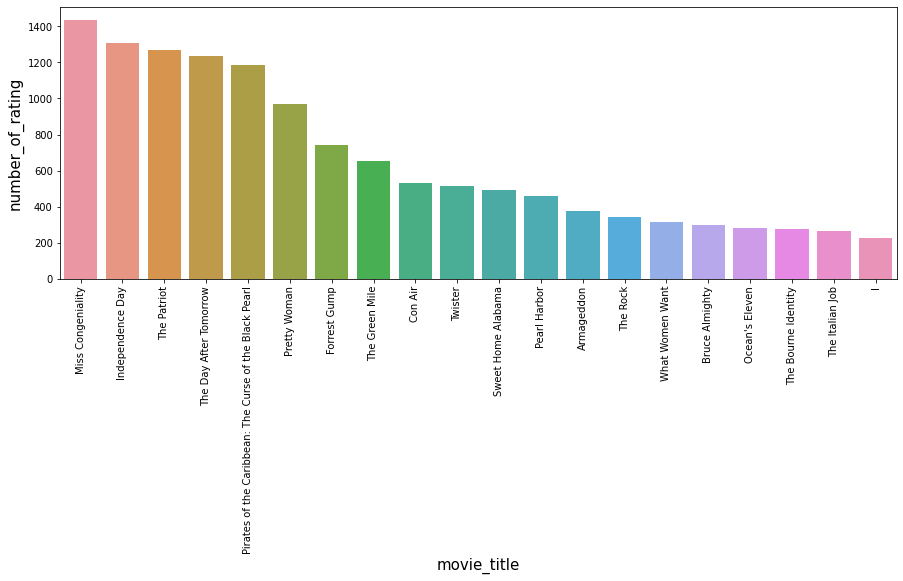

In [32]:
plt.figure(figsize=(15,5))
sns.barplot(most_rating_movies_name , movies_year_count.values)
plt.xlabel('movie_title' , size=15 )
plt.xticks(rotation=90)
plt.ylabel('number_of_rating',size = 15);

In [33]:
most_rating_movies.index

Int64Index([ 5317, 15124, 14313, 15205,  1905,  6287, 11283, 16377, 16242,
            12470, 15582,  9340,  6972, 12317,  2152,  3860, 15107,  6037,
             4432,  5496],
           dtype='int64')

In [34]:
avg_movies_rating = df.groupby('movie_id')['rating'].agg(['count','mean']).sort_values(ascending=False , by='mean')

In [35]:
avg_movies_rating.max()

count    232944.00000
mean          4.72327
dtype: float64

In [36]:
avg_movies_rating = df.groupby('movie_id')['rating'].agg(['count','mean']).sort_values(ascending=False , by='count')

In [37]:
avg_movies_rating[0:20]

,count,mean
movie_id,,
5317,232944,3.361267
15124,216596,3.724238
14313,200832,3.783854
15205,196397,3.442166
1905,193941,4.153908
6287,193295,3.905047
11283,181508,4.299910
16377,181426,4.306941
16242,178068,3.454411


> so none of the most rating movies has the highest rating but still all of them is above `3.4` which is still good 
- we can use these movies with highest rating ones for new users 

### recommendation system

<a id='build_user_profile'></a>
> we need to build user profile :
- to have our data that we can load to the model we need to have row for each user and a column for each movie and the values of this data will be rating values , and if the user did not rate a movie then the value will be zero
- so we are creating sparse_matrix from the dataframe ,it's shape is : `(user, movie)`

In [38]:
df.shape

(100480507, 3)

In [4]:
df_sparse_matrix = sparse.csr_matrix((df.rating.values, (df.customer_id.values,
                                               df.movie_id.values)),)

In [44]:
df_sparse_matrix.shape

(2649430, 17771)

> convert this sparse to normal matrix will get me `43.8 GB` matrix

In [47]:
if not os.path.isfile('df_sparse_matrix.csv'):
    sparse.save_npz("df_sparse_matrix.npz", df_sparse_matrix)
else : 
    df_sparse_matrix = sparse.load_npz('./df_sparse_matrix.npz')

In [48]:
df_sparse_matrix.count_nonzero()

100480507

<a id='dim_reduction'></a>
> we can not continue with this dimensions we need to reduce it
- note that our data now is sparce so we can not just use `PCA` , we will use `TruncatedSVD`:
    - this estimator does not center the data before computing the singular value decomposition. This means it can work with sparse matrices efficiently.

> spiliting the data : 

In [5]:
train_df = df_sparse_matrix[:int(df_sparse_matrix.shape[0]*0.80)]
test_df = df_sparse_matrix[int(df_sparse_matrix.shape[0]*0.80):]

In [38]:
train_df.shape

(2119544, 17771)

In [35]:
truncated_svd = TruncatedSVD(n_components=500 , random_state=42)
df_sparse_matrix_reduced = truncated_svd.fit_transform(train_df)

In [40]:
df_sparse_matrix_reduced.shape

(2119544, 500)


In [47]:
np.cumsum(truncated_svd.explained_variance_ratio_)[-1]

0.6431524897023524

> so we reach `64%` variance of the original data which is quite good 
- `500` component gave us `64%` variance and run in more than a day so i will just left it like that and won't try to improve it

In [29]:
from numpy import savetxt
if not os.path.isfile('df_sparse_matrix_reduced.csv'):
    savetxt('df_sparse_matrix_reduced.csv', df_sparse_matrix_reduced, delimiter=',')
else :
    df_sparse_matrix_reduced = pd.read_csv('df_sparse_matrix_reduced.csv',header=None)

> this took more than a day to run so let's save the reduced data 
- the size of the data on the disk is more than `25GB`

In [42]:
df_sparse_matrix_reduced[0:5]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.19809209e+01, -2.08091067e+00,  5.94768635e+00, ...,
         2.21305907e+00, -1.16318992e+00,  8.39983208e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.75627325e+00,  1.00136558e+00, -3.84788573e-01, ...,
         2.37421145e-01,  5.17946631e-02,  4.43373819e-01]])

> beacsue the data has alot of zeros , i will also convert it to sparse matrix and save it

In [43]:
df_sparse_matrix_reduced_sparse = sparse.csr_matrix(df_sparse_matrix_reduced)

In [8]:
if not os.path.isfile('./df_sparse_matrix_reduced_sparse.npz'):
    sparse.save_npz("df_sparse_matrix_reduced_sparse.npz", df_sparse_matrix_reduced_sparse)
else:
    df_sparse_matrix_reduced_sparse = sparse.load_npz('df_sparse_matrix_reduced_sparse.npz')

In [48]:
df_sparse_matrix_reduced_sparse.count_nonzero()

91076000

<a id='user_recommendation_using_KMeans'></a>
### user recommendation : 

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans , MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score

> using KMeans : 
- i will use `MiniBatchKMeans` becasue of data size
- and i will use `n_init` = 1 also because of data size as i don't want the algorism to run too much
- and also because of the data size i will use `memmap` to load the data

In [ ]:
filename = './df_sparse_matrix_reduced_sparse.npz'
X_mm = np.memmap(filename, dtype='float32', mode='write', shape= df_sparse_matrix_reduced_sparse.shape)
X_mm[:] = df_sparse_matrix_reduced_sparse

In [70]:

num_clusters = 10
model = MiniBatchKMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1) 
model.fit(X_mm)

KMeans(max_iter=100, n_clusters=10, n_init=1)

In [357]:
model.inertia_
# not too bad

27660.065534962087


> each row in my traing df will have a label indecate which cluster it belongs to
- so we can get the movies that beloges to each cluster and use them to predict
- i will use `train_df` which contain user profile data `row for each user`
- i will add another column to it that has the cluster lable
> when i recommend to user i will recommend a movie in the same cluster and with high rating 

In [139]:
df.head()

,customer_id,rating,movie_id
0,1488844,3,1
1,822109,5,1
2,885013,4,1
3,30878,4,1
4,823519,3,1


In [149]:
df_ = df.copy()

In [152]:
cluster_labels = model.labels_
if not os.path.isfile('cluster_labels.csv'):
    np.savetxt('cluster_labels.csv', cluster_labels, delimiter=",")
else : 
    cluster_labels = pd.read_csv('cluster_labels.csv')

In [155]:
df_['cluster'] = cluster_labels

In [158]:
user_ids = df_['customer_id'].values

In [161]:
for i in range(len(cluster_labels)):
    df_.loc[df['customer_id']==user_ids[i],'cluser'] = cluster_labels[i]
    print('.',end='')

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [4]:
from numpy import savetxt
if not os.path.isfile('df_with_cluster.csv'):
    savetxt('df_with_cluster.csv', df_, delimiter=',')
else :
    df_with_cluster = pd.read_csv('df_with_cluster.csv' , header=None , names=['user_id' , 'rating' , 'movie_id','cluster_label'])
    df_with_cluster['movie_id'] = df_with_cluster['movie_id'].astype(np.int16)
    df_with_cluster['user_id'] = df_with_cluster['user_id'].astype(np.int32) 
    df_with_cluster['rating'] = df_with_cluster['rating'] .astype(np.int8) 
    df_with_cluster['cluster_label'] = df_with_cluster['cluster_label'] .astype(np.int8) 

In [9]:
df_with_cluster.head()

,user_id,rating,movie_id,cluster_label
0,1490000,3,1,7
1,822000,5,1,1
2,885000,4,1,5
3,30900,4,1,0
4,824000,3,1,0


In [55]:
movies_cluster_sparse = sparse.csr_matrix((df_with_cluster.rating.values, (df_with_cluster.cluster_label.values,
                                               df_with_cluster.movie_id.values) ), dtype = np.int8)

In [238]:
movies_cluster = movies_cluster_sparse.toarray()

In [95]:
m , n = movies_cluster.shape 

In [239]:
movies_cluster_df = pd.DataFrame(movies_cluster , columns= np.arange(1,n+1))

In [240]:
if not os.path.isfile('movies_cluster_df.csv'):
    movies_cluster_df.to_csv('movies_cluster_df.csv')
else : 
    cluster_labels = pd.read_csv('movies_cluster_df.csv')

> so now each row represent a cluster and each column represent a movie with it's id as it's column name

<a id='top_10_movies_for_each_cluster'></a>
> before starting let's get the top ten rating movies in each cluster so we can recommend fast and do not do the computation again
- and i will use the arrays for movies recommendation also

In [241]:
titles = {'cluster_0':[] , 
        'cluster_1':[] ,
        'cluster_2':[] ,
        'cluster_3':[] ,
        'cluster_4':[] ,
        'cluster_5':[] ,
        'cluster_6':[] ,
        'cluster_7':[] ,
        'cluster_8':[] ,
        'cluster_9':[] 
        }

for i in range(m): #rows => each cluster
    for j in movies_cluster_df.columns:
        if (movies_cluster_df.loc[i,j] !=0): # if column not equal zero then it belonges to this cluster so we will save it to see the most
                titel = movies.loc[movies['movie_id']==j , 'title'].values[0]
                titles[f'cluster_{i}'].append(titel)
    

In [242]:
print(len(titles['cluster_1']))
print(len(titles['cluster_2']))

143
82


In [244]:
titles['cluster_1'][0:5]

['Isle of Man TT 2004 Review',
 'Character',
 'The Rise and Fall of ECW',
 'Sick',
 "Class of Nuke 'Em High 2"]

In [245]:
titles['cluster_2'][0:5]

['8 Man',
 'Full Frame: Documentary Shorts',
 'Lord of the Rings: The Return of the King: Extended Edition: Bonus Material',
 'Nature: Antarctica',
 'Immortal Beloved']

<a id='user_recommend_function'></a>
### user recommend function :  

In [305]:
def user_recommend(user_id):
    
    if user_id in df.customer_id.values :
        predict = model.predict(df_sparse_matrix_reduced[ df_sparse_matrix_reduced.index== user_id]) # remeber that each row represent a user
        user_movies = []
        high = len(titles[f'cluster_{predict[0]}'])
        # let's get random 10 movies
        rand_index = np.random.randint(low = 0 ,high = high,size = 10)
        
        for ind in rand_index:
            user_movies.append(titles[f'cluster_{predict[0]}'][ind])
        
        user_movies_df = pd.DataFrame(user_movies , columns=['title'] , index=np.arange(0,10))
        display(user_movies_df.head(10))
    
    else : 
    # if it was a new user then we will recommend the top rating movies that we define above
    # remember we already have a list with most rating movies
        print('recommending most rating movies for new user :')
        
        user_movies_df = pd.DataFrame(most_rating_movies_name[0:10] , columns=['title'] , index=np.arange(0,10))
        display(user_movies_df.head(10))

In [303]:
user_recommend(df.customer_id.values[2])

,title
0,Travel the World by Train: Africa
1,A Yank in the R.A.F.
2,Yellow
3,The Strongest Man in the World
4,Neil Diamond: Greatest Hits Live
5,Bear Cub
6,Spitfire Grill
7,Pitcher and the Pin-Up
8,A Killer Within
9,The Weather Underground


In [304]:
0 in df.customer_id.values

False

In [310]:
# there is no user with index 0
user_recommend(user_id=0)

recommending most rating movies for new user :


,title
0,Miss Congeniality
1,Independence Day
2,The Patriot
3,The Day After Tomorrow
4,Pirates of the Caribbean: The Curse of the Bla...
5,Pretty Woman
6,Forrest Gump
7,The Green Mile
8,Con Air
9,Twister


> let's make this function generic for any model so we can use it with different clustring tech : 

In [313]:
np.random.seed = 42
def user_recommend(user_id , model):
    
    if user_id in df.customer_id.values :
        predict = model.predict(df_sparse_matrix_reduced[ df_sparse_matrix_reduced.index== user_id]) 
        user_movies = []
        high = len(titles[f'cluster_{predict[0]}'])
        rand_index = np.random.randint(low = 0 ,high = high,size = 10)
        
        for ind in rand_index:
            user_movies.append(titles[f'cluster_{predict[0]}'][ind])
        
        user_movies_df = pd.DataFrame(user_movies , columns=['title'] , index=np.arange(0,10))
        display(user_movies_df.head(10))
    
    else : 
        print('recommending most rating movies for new user :')
        
        user_movies_df = pd.DataFrame(most_rating_movies_name[0:10] , columns=['title'] , index=np.arange(0,10))
        display(user_movies_df.head(10))

<a id='movie_recommend_function'></a>
### movie recommendation function

In [354]:
def movie_recommend(movie_title):
    movies_list = []
    for i in range (len(titles)):
        if movie_title in titles[f'cluster_{i}']:
            movies_list = titles[f'cluster_{i}'].copy()
            movies_list.remove(movie_title)
            break
    
    high = len(movies_list)
    
    rand_index = np.random.randint(low = 0 ,high = high,size = 10)
    user_movies = []    
    
    for ind in rand_index:
        user_movies.append(movies_list[ind])
    
    user_movies_df = pd.DataFrame(user_movies , columns=['title'] , index=np.arange(0,10))
    display(user_movies_df.head(10))

In [355]:
movie_recommend('Yellow')

,title
0,Unconstitutional: The War on Our Civil Liberties
1,Blood and Sand
2,Fatal Beauty
3,Neon Bible
4,The Game
5,Impostor
6,What the #$*! Do We Know!?
7,Fatal Beauty
8,Airplane II: The Sequel
9,Winter Kills


<a id='other_clustring_methods'></a>
### other clustring methods :

> DBSCAN

In [2]:
from sklearn.cluster import DBSCAN

In [ ]:
dbscan = DBSCAN(eps=0.4 , min_samples=5)
dbscan.fit(df_sparse_matrix_reduced_sparse)

In [18]:
dbscan.core_sample_indices_[0:10]

array([ 0,  2,  3,  5,  6,  7,  8,  9, 10, 11], dtype=int64)

In [24]:
dbscan.labels_[0:200]

array([ 0, -1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0, -1, -1,  0,  0, -1,  0, -1, -1,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1,  0, -1,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0, -1, -1,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0, -1, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0], dtype=int64)

> i tried different values for `eps` 
- if `eps` < `0.4` then the cell will run but all the labels will be `0` ot `-1` 
- if `eps` > `0.4` then the cell will run for so long almost `4` hours and then throw an error
- so i will consider `dbscan` was not able to cluster my data

> AgglomerativeClustering
- because 10 cluster worked well with `Kmeans` i will use it again with `AgglomerativeClustering`

In [26]:
from sklearn.cluster import AgglomerativeClustering

In [30]:
filename = './df_sparse_matrix_reduced.csv'
X_mm_array = np.memmap(filename, dtype='float32', mode='write', shape= df_sparse_matrix_reduced.shape)
X_mm_array[:] = df_sparse_matrix_reduced

In [33]:
agg = AgglomerativeClustering(n_clusters = 10 ,linkage="complete").fit(df_sparse_matrix_reduced)

MemoryError: Unable to allocate 3.64 TiB for an array with shape (499999500000,) and data type float64

> `AgglomerativeClustering` did not work with sparse data and there was an error , so i tried to train it using the data as array which was `25 GB` and there was an error because it will require `3.64 TiB` ram !!!!!
- and there is no partial_fit with it so i can not use batches !!!